#**Photovoltaic panel segmentation on building facades**

Ayca Duran*, Pedram Mirabian, Panagiotis Karapiperis, Christoph Waibel,
Bernd Bickel and Arno Schlueter

## SegFormer b5 Fine-Tuning

This notebook utilizes the dataset as adapted in the preprocessing step, and fine-tunes a pretrained SegFormer model for binary segmentation.

First, we load the required libraries.

In [31]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
!pip install evaluate

In [26]:
# Generic libraries
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
from PIL import Image
from evaluate import load
from tqdm import tqdm
from itertools import zip_longest

# PyTorch
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset # for creating PyTorch Dataset class
from torch import nn
from torchvision import transforms

# Transformers
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor

**Dataset**

In this section we define the dataset root dir, create the dataset class and construct the dataloaders. To do so, the input images are pre-processed by the SegFormer preprocessor (SegformerFeatureExtractor).

In [23]:
from pathlib import Path

base_path = Path("/content/drive/MyDrive/DLforPVFacades/paper/FinalCode/03_Segformer")

# Load root directory
#root_dir = 'dataset_pvonly'
#root_dir = 'dataset_with_nonpv'
root_dir = os.path.join(base_path, 'dataset_with_nonpv_color')
#root_dir = 'dataset_noaug'

In [24]:
# Create dataset class
class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, feature_extractor, mode):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            mode ("train" or "valid" or "test"): Whether to load "training" or "validation" or "testing" images + annotations.
        """
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        self.mode = mode

        self.img_dir = os.path.join(self.root_dir, self.mode, "images")
        self.ann_dir = os.path.join(self.root_dir, self.mode, "annotations")

        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
          image_file_names.extend(files)
        self.images = sorted(image_file_names)

        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
          annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = Image.open(os.path.join(self.img_dir, self.images[idx])).convert("RGB")
        segmentation_map = Image.open(os.path.join(self.ann_dir, self.annotations[idx])).convert("L")

        data_format = 'channels_first'
        encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt",data_format = data_format, do_reduce_labels = False)

        # Remove the batch dimension for each tensor
        for k,v in encoded_inputs.items():
         encoded_inputs[k].squeeze_()

        return encoded_inputs

In [25]:
# Load the pretrained feature extractor
#feature_extractor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b5-finetuned-ade-640-640")
feature_extractor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b5-finetuned-ade-640-640", do_normalize=False)  # Disables built-in normalization)
#feature_extractor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

/usr/local/lib/python3.12/dist-packages/transformers/image_processing_base.py:417: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type', 'reduce_labels'
  image_processor = cls(**image_processor_dict)


**(Optional): Custom Normalization based on dataset values**

In this section, we set custom mean and std values calculated for our dataset to the feature extractor. The values are normalized between 0 and 1. Best results did not use this step.

In [27]:
# Normalize mean and std values calculated for our dataset.
total_mean = [122.1287, 129.9507, 136.4666] #rgb
total_std = [72.9773, 72.1729, 77.3321]
normalized_mean = [m / 255 for m in total_mean]
normalized_std = [s / 255 for s in total_std]
normalized_mean = [round(value, 3) for value in normalized_mean]
normalized_std = [round(value, 3) for value in normalized_std]
print(normalized_mean)
print(normalized_std)

[0.479, 0.51, 0.535]
[0.286, 0.283, 0.303]


In [28]:
# Set feature extractor values to the calculated ones.
feature_extractor.image_mean = normalized_mean
feature_extractor.image_std = normalized_std
# Print for check
print(feature_extractor.image_mean)
print(feature_extractor.image_std)

[0.479, 0.51, 0.535]
[0.286, 0.283, 0.303]


In [ ]:
# Plot an image to check the feature extractor
image = Image.open(os.path.join(root_dir, "train/images/8232_302064735_345nopv_jpg.rf.2a0e877ad5da91398d144e0e53f0852f.jpg")).convert("RGB")
out = feature_extractor(image, return_tensors="pt")
plt.imshow(out.pixel_values.squeeze().permute(1,2,0))

## Dataloaders

In [ ]:
# Create the datasets and check their lengths
train_dataset = SemanticSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, mode = "train")
valid_dataset = SemanticSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, mode = "valid")
test_dataset = SemanticSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, mode = "test")

print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))
print("Number of validation examples:", len(test_dataset))

In [ ]:
# Define the batch size for the train dataloader (it is introdiced as a variable to be used in the naming convention of the saved model)
batch_size = 2

# Dreate Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers = 0)
valid_dataloader = DataLoader(valid_dataset, batch_size=2, shuffle=False, num_workers = 0)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers = 0)

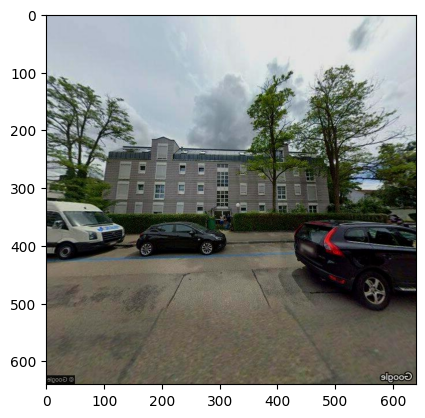

In [ ]:
# Plot the pixel values of the first image in the batch
batch = next(iter(train_dataloader))
plt.imshow(batch["pixel_values"][0].permute(1,2,0).numpy())

## Model

In this section of the notebook we load the pretrained model from Hugging Face, and modify its classification head for binary segmentation (0 = background, 1 = class).

In [ ]:
# ADE20K b5
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b5-finetuned-ade-640-640")

# ADE20K b0
#model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

In [ ]:
# Define number of classes
num_classes = 2  # Binary segmentation (foreground, background)

# Modify model classifiern00
model.decode_head.classifier = torch.nn.Conv2d(
    in_channels=768, # 256 # This should match the output channels from the previous layer
    out_channels=num_classes,    # Change to 2 for binary segmentation
    kernel_size=(1, 1)
)
print(model)

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

**OPTIONAL**: Freezing the pretrained model. Three different options.

In [ ]:
# Freeze everything except the classifier
"""
for name, param in model.named_parameters():
    if "decode_head.classifier" not in name:
        param.requires_grad = False
"""

# Unfreeze the classifier + linear_fuse + batch_norm:
"""
for name, param in model.named_parameters():
    if not any(layer in name for layer in ["classifier", "linear_fuse", "batch_norm"]):
        param.requires_grad = False
"""
# Unfreeze all of decode_head
"""
for name, param in model.named_parameters():
    if "decode_head" not in name:
        param.requires_grad = False
"""

Total parameters: 84,594,882
Trainable parameters: 3,151,874


In [ ]:
# Print total & trainable model parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 84,594,882
Trainable parameters: 84,594,882


## Training

In this section of the notebook we perform the training of the model. Intersection over Union (IoU) is used as the metric of choice. During training, both the model with the highest IoU on the validation set and the final weights are saved.

In [ ]:
# First, we define the metric
metric = load("mean_iou")

In [ ]:
# Define the checkpoint directory
checkpoint_dir = "trained_models/pvonly/segformer/b5" # To change:
# Create the checkpoint directory if it doesn't exist
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Initialize lists to save training data
train_ious = [0]
val_ious = [0]
train_losses = []
val_losses = []

# Training parameters
epochs = 20
lr = 0.00001 #0.00006

# Define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

# Optional: Discriminative learning rates for encoder and decoder
"""
encoder_lr = 0.00001
decoder_lr = 0.0005
# Separate encoder and decoder parameters
encoder_params = []
decoder_params = []

for name, param in model.named_parameters():
    if "decode_head" in name:  # decoder layers
        decoder_params.append(param)
    else:  # encoder layers
        encoder_params.append(param)

# Set up the optimizer with different learning rates
optimizer = torch.optim.AdamW([
    {'params': encoder_params, 'lr': encoder_lr},
    {'params': decoder_params, 'lr': decoder_lr}
])
"""

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.train()

for epoch in range(epochs):
   print("Epoch:", epoch)

   train_iou_interm = []
   iou_interm = []
   epoch_train_loss = 0
   epoch_val_loss = 0


   for idx, batch in enumerate(tqdm(train_dataloader)):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

        # evaluate
        with torch.no_grad():
          # Apply sigmoid to get probabilities
          upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
          predicted = upsampled_logits.argmax(dim=1)

          # metric expects predictions + labels as numpy arrays
          metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

          train_metrics = metric._compute(num_labels=2,
                            predictions=predicted.detach().cpu().numpy(),
                            references=labels.detach().cpu().numpy(),
                            ignore_index=None,
                            reduce_labels=False,
          )
          if 'per_category_iou' in train_metrics and 'per_category_accuracy' in train_metrics:
            train_iou = train_metrics['per_category_iou'][1]  # Class 1: PV
            train_accuracy = train_metrics['per_category_accuracy'][1]  # Class 1: PV
          else:
            train_iou = 0.0  # Default value if the metrics are not calculated correctly
            train_accuracy = 0.0  # Default value if the metrics are not calculated correctly

          train_iou_interm.append(train_iou)
          #break

   train_iou_interm = [ 1 if np.isnan(val) else val for val in train_iou_interm] # ignores nan replacing them with 1 for the images that have no pv
   train_mean_iou = np.mean(train_iou_interm)
   train_ious.append(train_mean_iou)

   epoch_train_loss /= len(train_dataloader)
   train_losses.append(epoch_train_loss)

   #EARLY STOPPING
   #after every epoch get a validation score for early stopping
   for idx, batch in enumerate(tqdm(valid_dataloader)):

        model.to(device)

        with torch.no_grad():

          # get the inputs;
          pixel_values = batch["pixel_values"].to(device)
          labels = batch["labels"].to(device)

          # Forward pass
          outputs = model(pixel_values=pixel_values, labels=labels)
          logits = outputs.logits #.cpu()
          loss = outputs.loss #.cpu()

          epoch_val_loss += loss.item()

          upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
          predicted = upsampled_logits.argmax(dim=1)
          # note that the metric expects predictions + labels as numpy arrays
          metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

          # Calculate IoU and Loss
          metrics = metric._compute(num_labels=2,
                            predictions=predicted.detach().cpu().numpy(),
                            references=labels.detach().cpu().numpy(),
                            ignore_index=None,
                            reduce_labels=False,
          )

          # Check if the expected keys exist in the metrics dictionary
          if 'per_category_iou' in metrics and 'per_category_accuracy' in metrics:
            iou = metrics['per_category_iou'][1]  # Class 1: PV
            accuracy = metrics['per_category_accuracy'][1]  # Class 1: PV
          else:
            iou = 0.0  # Default value if the metrics are not calculated correctly
            accuracy = 0.0  # Default value if the metrics are not calculated correctly

          iou_interm.append(iou)
          #break

   # Calculate Validation loss
   epoch_val_loss /= len(valid_dataloader)
   val_losses.append(epoch_val_loss)

   # Calculate Validation IoU
   iou_interm = [ 1 if np.isnan(val) else val for val in iou_interm] # ignores nan replacing them with 1 for the images that have no pv
   mean_iou = np.mean(iou_interm)
   if mean_iou > max(val_ious):
          # Save the best model checkpoint
          checkpoint_path = os.path.join(checkpoint_dir, f"best_model_{epochs}epochs_{lr}lr_batch{batch_size}.pt")
          torch.save(model.state_dict(), checkpoint_path)

   val_ious.append(mean_iou)

   print("Epoch Train Loss:", epoch_train_loss)
   print("Epoch Val Loss:", epoch_val_loss)
   print("Train_Mean_iou:", train_mean_iou)
   print("Val_Mean_iou:", mean_iou)
   #break

# At the end, save final weights as well
final_checkpoint_path = os.path.join(checkpoint_dir, f"best_model_{epochs}epochs_{lr}lr_batch{batch_size}_final_weights.pt")
torch.save(model.state_dict(), final_checkpoint_path )
print(f"Model saved to {checkpoint_path}")

# Save training data in a csv file
# Prepare data by combining them into rows
column_names = ["val_ious", "train_ious", "val_losses", "train_losses"]
rows = zip_longest(val_ious, train_ious, val_losses, train_losses, fillvalue="")

# Write to CSV
with open(os.path.join(checkpoint_dir,'training_data.csv'), mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(column_names)
    writer.writerows(rows)

print("CSV saved as training_data.csv")

Epoch: 0


  0%|          | 0/2895 [00:00<?, ?it/s]c:\Users\panag\anaconda3\envs\torch\Lib\site-packages\datasets\features\image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
  0%|          | 0/51 [00:10<?, ?it/s]


Epoch Train Loss: 0.00021782501991548687
Epoch Val Loss: 0.010950235759510714
Train_Mean_iou: 0.0
Val_Mean_iou: 0.0011866388013177004
Model saved to trained_models/pvonly/segformer/b5\best_model_20epochs_1e-05lr_batch2.pt
CSV saved as training_data.csv


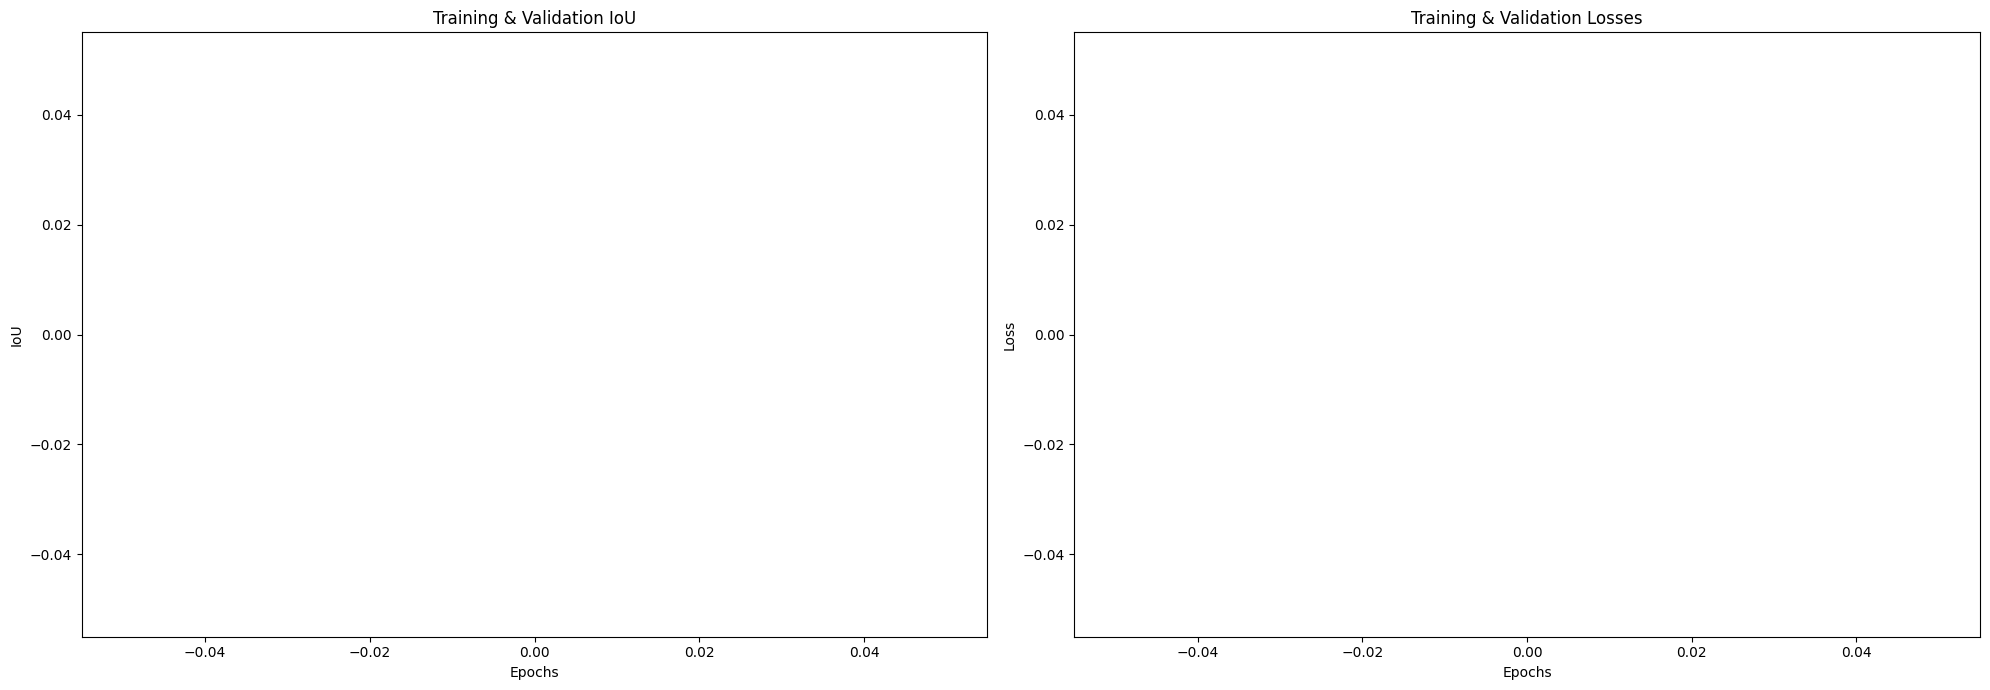

In [ ]:
# Plot training data
fig, axes = plt.subplots(1, 2, figsize=(20, 7))
xs = [x for x in range(len(val_ious))]
ys = [x for x in range(len(val_losses))]

axes[0].plot(xs, val_ious)
axes[0].plot(xs, train_ious)
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("IoU")
axes[0].set_title("Training & Validation IoU")
axes[0].grid

axes[1].plot(ys, val_losses)
axes[1].plot(ys, train_losses)
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].set_title("Training & Validation Losses")
axes[1].grid

plt.tight_layout()
plt.show
plt.savefig(os.path.join(checkpoint_dir,"training_data"))

## Inference

In this part of the notebook the fine-tuned model is loaded to run inference on the test set.

In [30]:
torch.cuda.is_available()

False

In [ ]:
from transformers import SegformerForSemanticSegmentation
import torch

checkpoint_path = os.path.join(base_path, Path("trained_models/with_nonpv_color/segformer/b5/training_3"))
trained_model = os.path.join(checkpoint_path, Path("best_model_10epochs_3e-05lr_batch2.pt"))
predictions_save_path = os.path.join(checkpoint_path, "masks")
figs_save_path = os.path.join(checkpoint_path, "figs")
csv_save_path = os.path.join(checkpoint_path, "csv")

os.makedirs(predictions_save_path, exist_ok=True)
os.makedirs(figs_save_path, exist_ok=True)
os.makedirs(csv_save_path, exist_ok=True)

# ADE20K b5 / b1
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b5-finetuned-ade-640-640")
#model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model.decode_head.classifier = torch.nn.Conv2d(
    in_channels=768, # 256 # This should match the output channels from the previous layer
    out_channels=2,    # Change to 2 for binary segmentation
    kernel_size=(1, 1)
)

model.load_state_dict(torch.load(trained_model))
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

  0%|          | 0/105 [00:00<?, ?it/s]c:\Users\panag\anaconda3\envs\torch\Lib\site-packages\datasets\features\image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
  0%|          | 0/105 [00:09<?, ?it/s]

Test_Mean_iou_TP: 0.9637783654141812
Test_Mean_iou_TPFN: 0.9637783654141812
Test_Mean_f1: 0.9815551310556477
Test_Mean_precision: 0.9903943377148635
Test_Mean_recall: 0.972872307405798
CSV files saved!


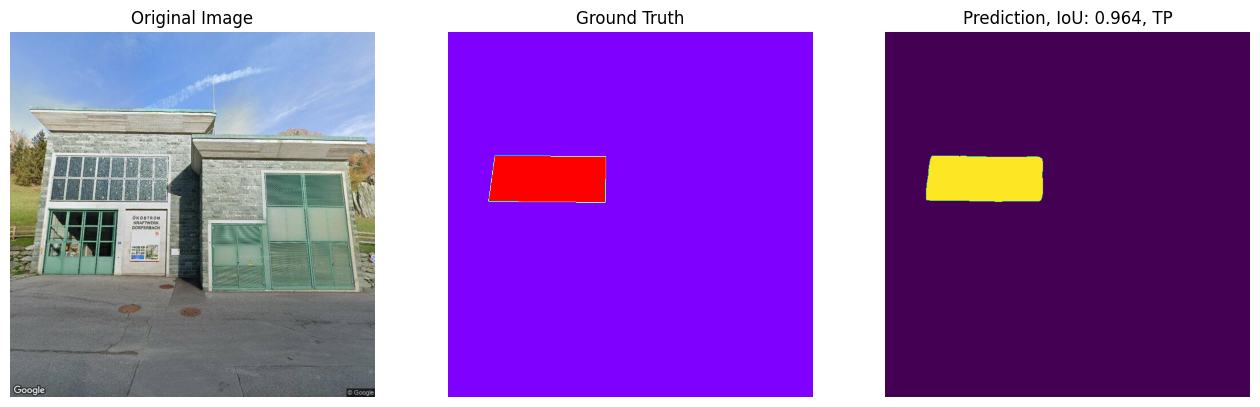

In [ ]:
import cv2
from sklearn.metrics import precision_score, recall_score

# Load the metric for evaluation
mean_iou = load("mean_iou")
precision = load("precision","multilabel")
recall = load("recall")
f1_metric = load("f1")

# Initialize lists and counters to save test data
test_ious_TP = []
test_ious_TPFN = []
test_precision = []
test_recall = []
test_f1 = []

TP = 0
TN = 0
FP = 0
FN = 0

for idx, batch in enumerate(tqdm(test_dataloader)):

    model.to(device)
    model.eval()
    with torch.no_grad():

        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        #outputs = model(pixel_values=pixel_values)
        outputs = model(pixel_values=pixel_values, labels=labels)
        logits = outputs.logits #.cpu()
        loss = outputs.loss #.cpu()


        upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)

        # Option 1: Get the predicted class with argmax
        #predicted = upsampled_logits.argmax(dim=1)

        # Option 2: Get the predicted probabilities and apply a threshold

        probs = torch.nn.functional.softmax(upsampled_logits, dim=1)  # Convert logits to probabilities
        confidence_threshold = 0.2  # Adjust as needed

        # Get the probability of class 1 (foreground)
        foreground_probs = probs[:, 1, :, :]

        # Apply threshold: set to 1 if prob ≥ threshold, else 0 (background)
        predicted = (foreground_probs >= confidence_threshold).long()

        predicted = predicted.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()

        # Save mask
        filename = str(idx) + ".png"
        cv2.imwrite(os.path.join(predictions_save_path, filename), predicted[0])

        # note that the metric expects predictions + labels as numpy arrays
        mean_iou.add_batch(predictions=predicted, references=labels)
        #precision.add_batch(predictions=[predicted], references=[labels])
        #recall.add_batch(predictions=predicted.flatten(), references=labels.flatten())
        f1_metric.add_batch(predictions=predicted.flatten(), references=labels.flatten())
        """
        # Calculate metrics
        metrics = metric._compute(num_labels=2, # len(id2label)
                        predictions=predicted.detach().cpu().numpy(),
                        references=labels.detach().cpu().numpy(),
                        ignore_index=None, #255
                        reduce_labels=False, # we've already reduced the labels before)
        )
        """
        iou_result = mean_iou.compute(num_labels=2, predictions=predicted, references=labels, ignore_index=None, reduce_labels=False)
        #precision_result = precision.compute(num_labels=2, predictions=predicted.flatten().tolist(), references=labels.flatten().tolist(), ignore_index=None, reduce_labels=False)
        #§recall_result = recall.compute(num_labels=2, predictions=predicted.flatten(), references=labels.flatten(), ignore_index=None, reduce_labels=False)
        f1_result = f1_metric.compute(predictions=predicted.flatten(), references=labels.flatten(), average="binary")


        # Check if the expected keys exist in the metrics dictionary
        iou = iou_result['per_category_iou'][1]  # Assuming class 1 is your foreground
        #precision = precision_result['precision']
        f1 = f1_result["f1"]
        precision = precision_score(labels.flatten(), predicted.flatten())
        recall = recall_score(labels.flatten(), predicted.flatten())

        if len(np.unique(labels.squeeze(0))) == 2: # if there is pv in ground truth
            if len(np.unique(predicted.squeeze(0))) == 2: # if there is pv in prediction
                test_ious_TP.append(iou)
                test_ious_TPFN.append(iou)
                TP += 1
                pred_type = "TP"
            else: # if there is no pv in prediction
                test_ious_TPFN.append(iou) # TEST: for counting
                FN += 1
                pred_type = "FN"
        else: # if ground truth has no pv
            if len(np.unique(predicted.squeeze(0))) == 2: # if there is pv in prediction
                FP += 1
                pred_type = "FP"
            else: # if there is no pv in prediction
                TN += 1
                pred_type = "TN"

        test_f1.append(f1)
        test_precision.append(precision)
        test_recall.append(recall)


        # Display the original image and the predicted segmentation map side by side
        fig, ax = plt.subplots(1, 3, figsize=(16, 8))
        ax[0].imshow(pixel_values.squeeze().permute(1,2,0).cpu().numpy())
        ax[0].set_title("Original Image")
        ax[0].axis("off")

        ax[1].imshow(labels[0], cmap="rainbow") #.squeeze().cpu().numpy()
        ax[1].set_title("Ground Truth")
        ax[1].axis("off")

        ax[2].imshow(predicted[0]) #.squeeze().cpu().numpy()
        ax[2].set_title(f"Prediction, IoU: {round(iou,3)}, {pred_type}")
        ax[2].axis("off")
        #plt.show
        filename = str(idx) + ".png"
        plt.savefig(os.path.join(figs_save_path,filename), bbox_inches='tight')
        #break"

    #break

# Calculate Test Metrics
test_mean_iou_TP = np.mean(test_ious_TP)
test_mean_iou_TPFN = np.mean(test_ious_TPFN)
test_mean_f1 = np.mean(test_f1)
test_mean_precision = np.mean(test_precision)
test_mean_recall = np.mean(test_recall)
print("Test_Mean_iou_TP:", test_mean_iou_TP)
print("Test_Mean_iou_TPFN:", test_mean_iou_TPFN)
print("Test_Mean_f1:", test_mean_f1)
print("Test_Mean_precision:", test_mean_precision)
print("Test_Mean_recall:", test_mean_recall)


# Save metrics in a csv file
# Create a DataFrame with mean only in the first row
test_mean_column_TP = [test_mean_iou_TP] + [''] * (len(test_ious_TP) - 1)
test_mean_column_TPFN = [test_mean_iou_TPFN] + [''] * (len(test_ious_TPFN) - 1)
df = pd.DataFrame({
    'test_ious_TP': test_ious_TP,
    'test_ious_TPFN': test_ious_TPFN,
    'test_f1': test_f1,
    'test_precision': test_precision,
    'test_recall': test_recall,
    'test_mean_iou_TP': test_mean_column_TP,
    'test_mean_iou_TPFN': test_mean_column_TPFN
})
csv_filename = 'test_ious.csv'
df.to_csv(os.path.join(csv_save_path, csv_filename), index=False)

# Confusion matrix
df2 = pd.DataFrame([{
    'TP': TP,
    'TN': TN,
    'FP': FP,
    'FN': FN
}])
csv_cm_filename = 'confusion_matrix.csv'
df2.to_csv(os.path.join(csv_save_path, csv_cm_filename), index=False)

print("CSV files saved!")